# Homework Assignmet 3: HMMs on Part-of-Speech tagging

### Submitted by: Namya Hemal Shah (5953694298)

This assignment gives you hands-on experience on using HMMs on part-of- speech tagging. We will use the Wall Street Journal section of the Penn Treebank to build an HMM model for part-of-speech tagging. In the folder named data, there are three files: train, dev and test. In the files of train and dev, we provide you with the sentences with human-annotated part-of-speech tags. In the file of test, we provide only the raw sentences that you need to predict the part-of-speech tags. The data format is that, each line contains three items separated by the tab symbol ‘\t’. The first item is the index of the word in the sentence. The second item is the word type and the third item is the corresponding part-of-speech tag. There will be a blank line at the end of one sentence.

# Importing Important Libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/namyashah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/namyashah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import re

In [4]:
from collections import Counter

In [43]:
from decimal import *

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import os
import json

# Vocablary Creation

The first task is to create a vocabulary using the training data. In HMM, one important problem when creating the vocabulary is to handle unknown words. One simple solution is to replace rare words whose occurrences are less than a threshold (e.g. 3) with a special token ‘< unk >’.
Task. Creating a vocabulary using the training data in the file train and output the vocabulary into a txt file named vocab.txt. The format of the vocabulary file is that each line contains a word type, its index in the vocabulary and its occurrences, separated by the tab symbol ‘\t’. The first line should be the special token ‘< unk >’ and the following lines should be sorted by its occurrences in descending order. Note that we can only use the training data to create the vocabu- lary, without touching the development and test data. What is the selected threshold for unknown words replacement? What is the total size of your vocabulary and what is the total occurrences of the special token ‘< unk >’ after replacement?

In [7]:
# Defining the path and features
path = '/Users/namyashah/Documents/USC Schooling/NLP/HW3/data/train'
features = ['indexes','word','given_tags']

In [8]:
# Reading the train dataset
train_data = pd.read_csv(path,  sep='\t', names = features)
print(train_data.shape)
train_data.head(5)

(912095, 3)


,indexes,word,given_tags
0,1,Pierre,NNP
1,2,Vinken,NNP
2,3,",",","
3,4,61,CD
4,5,years,NNS


### Data Cleaning

In [9]:
#fix numbers

def clean_nums(word):
    word = re.sub(r'[0-9_]+','', word)
    return ''.join(word.split())

In [10]:
# remove characters except for alphabets and numbers

def clean_punct(word):
    word = re.sub('[\W_]+', '', word)
    return ''.join(word.split())

In [11]:
#removing words that are non alphabetic characters
def process_words(words):
    words = clean_nums(words)
    words = clean_punct(words)
    return(words)

train_data['word'] = train_data['word'].apply(str)
train_data['word'] = train_data['word'].apply(process_words)
train_data

,indexes,word,given_tags
0,1,Pierre,NNP
1,2,Vinken,NNP
2,3,,","
3,4,,CD
4,5,years,NNS
...,...,...,...
912090,22,to,TO
912091,23,San,NNP
912092,24,Francisco,NNP
912093,25,instead,RB


In [12]:
# obtaining all the words in the dataset in a list
words=(train_data['word'].str.lower()).tolist()
print(len(words))

912095


In [13]:
# removing words that are blank
temp_wd = []
count_wd_dropped = 0
for wd in words:
    if wd not in '':
        temp_wd.append(wd)
        count_wd_dropped+=1
words = temp_wd
print(len(words))

769379


Here we remove those words that are either all numerals(for example, '123') or all non alphabetic characters(for example, '#/+') and count them as unknown words too because they hold no significance in POS tagging. The only by-product of this process is that the numeral values and non alphabetic characters within the words are also removed for example 'pier24one' is now 'pierone'.

In [14]:
# creating an object for the Counter() function from the collections library for finding occurances of each word in the train data set
occurrences = Counter()

In [15]:
# finding the occurance of each word in the training data set
for word in words:
    occurrences[word]+=1

In [16]:
# sorting the words in the Descending Order
occurence_dict =  dict(occurrences)
len(occurence_dict)
sorted_tuple = sorted(occurence_dict.items(), key = lambda x:x[1], reverse = True)
sorted_dict = dict(sorted_tuple)

In [17]:
# creating a pandas data frame for the words and its ocurrances
keys = list(sorted_dict.keys())
vals =  list(sorted_dict.values())
word_freq_dict =  {'words':keys, 'occurrences':vals}
word_df = pd.DataFrame.from_dict(word_freq_dict)
og_words_len = len(word_df)
word_df.head(5)

,words,occurrences
0,the,46144
1,of,22176
2,to,21468
3,a,19485
4,in,16320


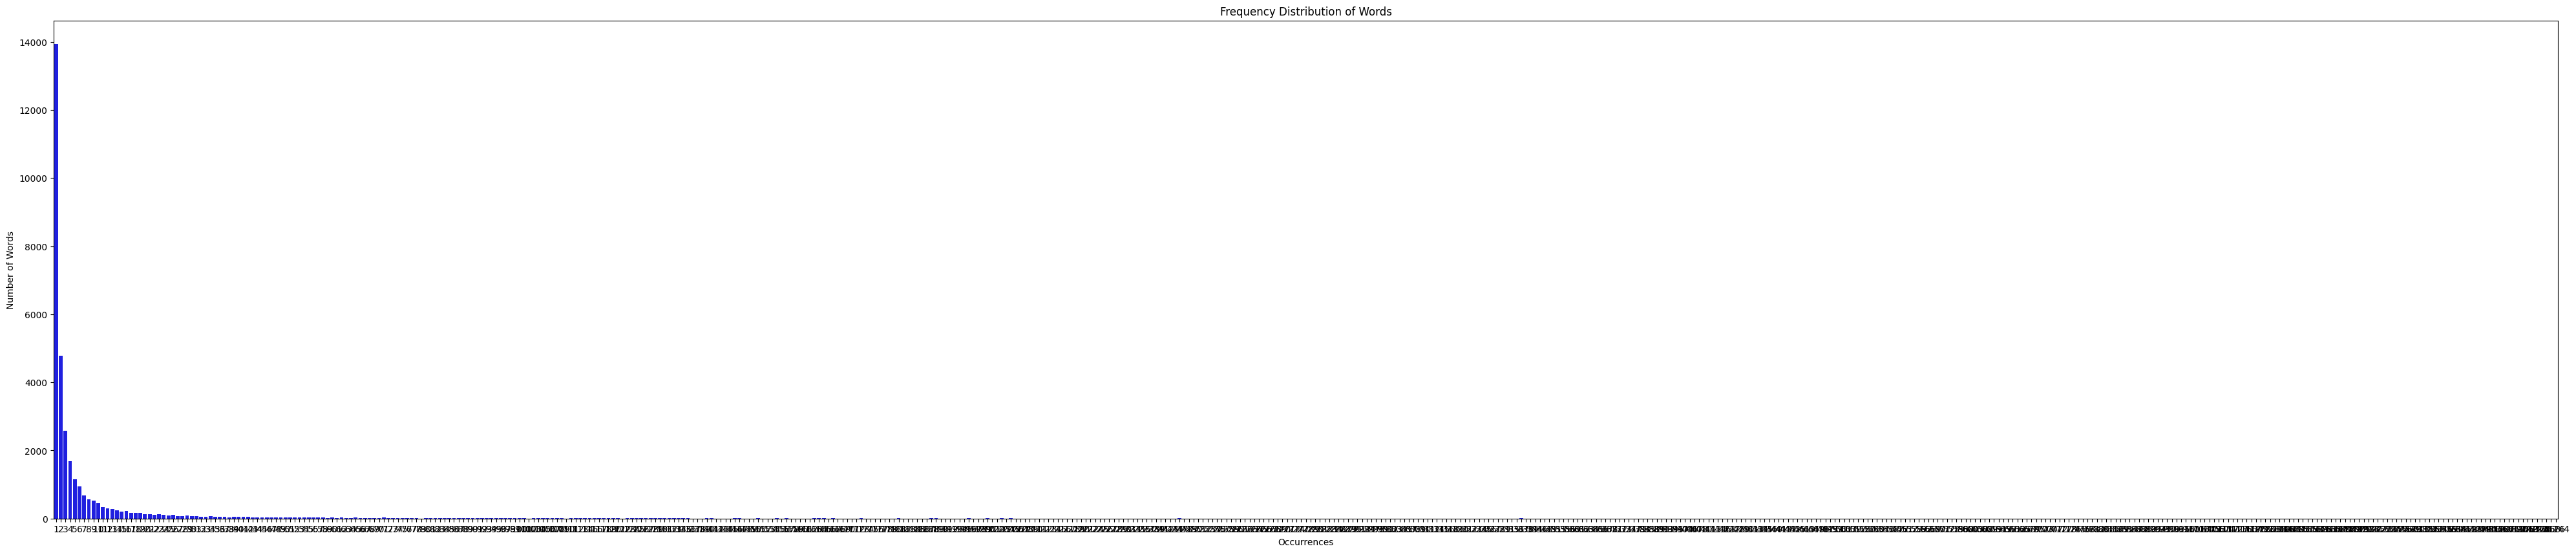

In [18]:
# ploting the ocurrances

frequency_counts = word_df.groupby('occurrences').size().reset_index(name='now')

plt.figure(figsize=(50,10))
sns.barplot(data=frequency_counts, x='occurrences', y='now', color='blue')
plt.xlabel('Occurrences')
plt.ylabel('Number of Words')
plt.title('Frequency Distribution of Words')
plt.show()

In [19]:
first_quartile_value_now = frequency_counts['now'].quantile(0.25)
first_quartile_value_occ = frequency_counts['occurrences'].quantile(0.25)
print('The lower quartile for the frequency of occurrences is ',first_quartile_value_occ)
print('This lower quartile for the frequency of occurrences lies in the words with occurrence ',first_quartile_value_now)
threshold = first_quartile_value_now
print('Thus the threshold value for unknown words replacement is ',threshold)

The lower quartile for the frequency of occurrences is  134.5
This lower quartile for the frequency of occurrences lies in the words with occurrence  1.0
Thus the threshold value for unknown words replacement is  1.0


In [20]:
# creating vocabulary with the replaced unknown words
breaking_df = word_df.loc[word_df['occurrences'] > int(threshold)]
break_len = breaking_df.shape[0]
temp_dict = {
    'words':'<unk>',
    'occurrences':og_words_len - break_len + count_wd_dropped}
temp_df = pd.DataFrame(temp_dict, index=[0])

vocabulary = pd.concat([temp_df,breaking_df], ignore_index=True, sort=False)
print('The numer of words before replacing the unknown words',og_words_len+count_wd_dropped)
print('The number of words after replacing the unknown words',vocabulary.shape[0])

The numer of words before replacing the unknown words 802484
The number of words after replacing the unknown words 19178


In [21]:
#introducing the indexes
indexes = [i for i in range (0,vocabulary.shape[0])]
vocabulary.insert(loc = 0, column = 'index', value = indexes)


In [22]:
print('The total size of your vocabulary is',vocabulary.shape[0])
count_wd_dropped = count_wd_dropped + vocabulary['occurrences'].iloc[0]
print('The total occurrences of the special token ‘< unk >’ after replacement is',count_wd_dropped)
vocabulary.head(5)

The total size of your vocabulary is 19178
The total occurrences of the special token ‘< unk >’ after replacement is 1552686


,index,words,occurrences
0,0,<unk>,783307
1,1,the,46144
2,2,of,22176
3,3,to,21468
4,4,a,19485


In [23]:
# storing the output file locally
os.makedirs('/Users/namyashah/Documents/USC Schooling/NLP/HW3/output', exist_ok=True)  
vocabulary.to_csv('/Users/namyashah/Documents/USC Schooling/NLP/HW3/output/vocab.txt',sep='\t',index=False)

# Model Learning

Task. Learning a model using the training data in the file train and output the learned model into a model file in json format, named hmm.json. The model file should contains two dictionaries for the emission and transition parameters, respectively. The first dictionary, named transition, contains items with pairs of (s,s′) as key and t(s′|s) as value. The second dictionary, named emission, contains items with pairs of (s, x) as key and e(x|s) as value. How many transition and emission parameters in your HMM?

In [24]:
train_data = pd.read_csv(path,  sep='\t', names = features)
print(train_data.shape)
train_data.head(5)

(912095, 3)


,indexes,word,given_tags
0,1,Pierre,NNP
1,2,Vinken,NNP
2,3,",",","
3,4,61,CD
4,5,years,NNS


In [25]:
# counting the number of times each tag has occured
total_tag_count = train_data.groupby('given_tags').size().reset_index(name = 'count')
total_tag_count.head(5)

,given_tags,count
0,#,127
1,$,6937
2,'',6622
3,",",46480
4,-LRB-,1305


## Creating Emission Matrix (E)

In [26]:
# counting the number of times a pair of (word,tag) has occured in the training data
word_to_tag_count = train_data.groupby(['word', 'given_tags']).size().reset_index(name = 'count')
print(word_to_tag_count.shape)
word_to_tag_count.head(5)

(50284, 3)


,word,given_tags,count
0,!,.,66
1,#,#,127
2,$,$,6762
3,%,JJ,10
4,%,NN,4708


In [27]:
# evaluating the emission matrix
i_vals = range(word_to_tag_count.shape[0])
emission = {}

for i in i_vals:
    word = word_to_tag_count.iloc[i][0]
    tag = word_to_tag_count.iloc[i][1]
    tag_count_temp = total_tag_count[total_tag_count['given_tags'].isin([tag])]
    count1 = int(tag_count_temp.iloc[0][1])
    count2 = int(word_to_tag_count.iloc[i][2])
    key = ''+tag+','+word
    emission[key] = count2/count1

/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/3032883246.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = word_to_tag_count.iloc[i][0]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/3032883246.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tag = word_to_tag_count.iloc[i][1]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/3032883246.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

## Creating Transition Matrix (A)

In [28]:
# counting the number of times the pair of (tag1,tag2) has occured in the training data
train_data['step_val'] = train_data['given_tags'].shift(-1)
tag_to_tag_count = train_data.groupby(['given_tags','step_val']).size().reset_index(name = 'count')
tag_to_tag_count.head(5)

,given_tags,step_val,count
0,#,",",1
1,#,CD,126
2,$,CD,6882
3,$,JJ,55
4,'',$,1


In [29]:
total_num_words = train_data.shape[0]
print(total_num_words)

912095


In [30]:
# evaluating the start probabilities of each tag
i_vals = range(total_tag_count.shape[0])
transition = {}

for i in i_vals:
    tag = total_tag_count.iloc[i][0]
    tag_count_temp = total_tag_count[total_tag_count['given_tags'].isin([tag])]
    count1 = int(tag_count_temp.iloc[0][1])
    key = 'start,'+tag
    transition[key] = count1/total_num_words

/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/3113536579.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tag = total_tag_count.iloc[i][0]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/3113536579.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count1 = int(tag_count_temp.iloc[0][1])


In [31]:
# evaluating the rest of the transition matrix
i_vals = range(tag_to_tag_count.shape[0])

for i in i_vals:
    tag1 = tag_to_tag_count.iloc[i][0]
    tag2 = tag_to_tag_count.iloc[i][1]
    tag_count_temp = total_tag_count[total_tag_count['given_tags'].isin([tag1])]
    count1 = int(tag_count_temp.iloc[0][1])
    count3 = int(tag_to_tag_count.iloc[i][2])
    key = ''+tag1+','+tag2
    transition[key] = count3/count1

/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/906391021.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tag1 = tag_to_tag_count.iloc[i][0]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/906391021.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tag2 = tag_to_tag_count.iloc[i][1]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/906391021.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

## Storing both the matrices in a json file

In [32]:
# combining the dictionaries
hmm_dict = {'emission': emission, 'transition': transition}

In [33]:
with open('/Users/namyashah/Documents/USC Schooling/NLP/HW3/output/hmm.json', 'w') as json_file:
    json.dump(hmm_dict, json_file, indent=4)

# Greedy Decoding with HMM

Task. Implementing the greedy decoding algorithm and evaluate it on the development data. What is the accuracy on the dev data? Predicting the part-of-speech tags of the sentences in the test data and output the predic- tions in a file named greedy.out, in the same format of training data.
We also provide an evaluation script eval.py to evaluate the results of the model. To use the script, you need to prepare your prediction file in the same format as the training data, then execute the command line:

python eval.py -p output/greedy.out -g data/dev

In [34]:
# Defining the path and features
path2 = '/Users/namyashah/Documents/USC Schooling/NLP/HW3/data/dev'
features2 = ['indexes','word','given_tags']

In [35]:
# Reading the train dataset
dev_data = pd.read_csv(path2,  sep='\t', names = features2)
print(dev_data.shape)
dev_data.head(5)

(131768, 3)


,indexes,word,given_tags
0,1,The,DT
1,2,Arizona,NNP
2,3,Corporations,NNP
3,4,Commission,NNP
4,5,authorized,VBD


In [36]:
# ensuring all the words are of string type
dev_data['word'] = dev_data['word'].apply(str)
dev_data.head(5)

,indexes,word,given_tags
0,1,The,DT
1,2,Arizona,NNP
2,3,Corporations,NNP
3,4,Commission,NNP
4,5,authorized,VBD


In [37]:
# initializing basic parameters
total_tag_count['given_tags'] = total_tag_count['given_tags'].apply(str)
tags = (total_tag_count['given_tags']).tolist()
path = []
p_val = {}
max_probability = 0
i_vals = range(dev_data.shape[0])

#### Logic Behind my code for Greedy Algorithm:

When we encounter id = 1, it means a new sentence has began, so here we take the start values from the transition matrix.
p_val is a dictionary that stores the probabilities of A[start,tag]*E[tag,word] in case these values exist in the matrix or 0 if it doesn't.
The maximum probability value from the dictionary is selected and the tag currosponding to it, rest all are discarded.

when we encounter id to be anything other than 1, it means a sentence is on-going, so here we take the previous tag to new tag values from the transition matrix.
p_val is a dictionary that stores the probabilities of A[tag1,tag2]*E[tag2,word] in case these values exist in the matrix or 0 if it doesn't.
The maximum probability value from the dictionary is selected and the tag currosponding to it, rest all are discarded.

In [38]:
# executing the greedy algorithm

for i in i_vals:
    # initializing the varing parameters in this algorithm
    temp_path =''
    id = dev_data.iloc[i][0]
    word = dev_data.iloc[i][1]
    p_val = {}

    if id == 1:
        for tag in tags:
            tkey = 'start,'+tag
            ekey = ''+tag+','+word
            if transition.get(tkey) is not None and emission.get(ekey) is not None:
                p_val[tag] = transition[tkey]*emission[ekey]
            else:
                p_val['DT'] = 0
        if max(p_val.values()) != 0:
            max_probability = max(p_val.values())
            temp_path = [i for i in p_val if p_val[i]==max_probability][0]
        else:
            temp_path = 'DT'
    else:
        for tag2 in tags:
            if path:
                tag1 = path[-1]
            else:
                tag1 = 'start'
            tkey = ''+tag1+','+tag2
            ekey = ''+tag2+','+word
            if transition.get(tkey) is not None and emission.get(ekey) is not None:
                p_val[tag2] = max_probability*transition[tkey]*emission[ekey]
            else:
                p_val['NNP'] = 0
        if max(p_val.values()) != 0:
            max_probability = max(p_val.values())
            temp_path = [i for i in p_val if p_val[i]==max_probability][0]
        else:
            temp_path = 'NNP'
    
    path.append(temp_path)

/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/900646807.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = dev_data.iloc[i][0]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/900646807.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = dev_data.iloc[i][1]


In [39]:
# creating a dataframe for final output
greedy_df = pd.DataFrame()
greedy_df['indexes'] = dev_data['indexes']
greedy_df['word'] = dev_data['word']
greedy_df['tags'] = path

greedy_df.head(5)

,indexes,word,tags
0,1,The,NNP
1,2,Arizona,NNP
2,3,Corporations,NNS
3,4,Commission,NN
4,5,authorized,VBD


In [40]:
# storing the final output locally
with open('/Users/namyashah/Documents/USC Schooling/NLP/HW3/output/greedy.out', 'w') as out:
    for row in greedy_df.values:
        out.write(f"{row[0]}\t{row[1]}\t{row[2]}\n")
    out.write(f'\n')

# Viterbi Decoding with HMM

Task. Implementing the viterbi decoding algorithm and evaluate it on the development data. What is the accuracy on the dev data? Predicting the part-of-speech tags of the sentences in the test data and output the predictions in a file named viterbi.out, in the same format of training data.

In [44]:
# Defining the path and features
path3 = '/Users/namyashah/Documents/USC Schooling/NLP/HW3/data/dev'
features3 = ['indexes','word','given_tags']

In [45]:
# Reading the train dataset
dev_data = pd.read_csv(path3,  sep='\t', names = features3)
#coverting all words to strings
dev_data['word'] = dev_data['word'].apply(str)
print(dev_data.shape)
dev_data.head(5)

(131768, 3)


,indexes,word,given_tags
0,1,The,DT
1,2,Arizona,NNP
2,3,Corporations,NNP
3,4,Commission,NNP
4,5,authorized,VBD


In [46]:
# initializing basic parameters
total_tag_count['given_tags'] = total_tag_count['given_tags'].apply(str)
tags = (total_tag_count['given_tags']).tolist()
paths = {}
main_path = []
i_vals = range(1, dev_data.shape[0])

#setting context for multiplication
mycontext = Context(prec=10)
setcontext(mycontext)

In [47]:
# Here we will only keep those paths which either have a unique last tag or has highest probabilities among those paths with same last tag.
def getmaxpaths(paths):
    result = {}
    for key, value in paths.items():
        last_element = key.split('|')[-1]
        if last_element not in result or value > result[last_element][1]:
            result[last_element] = (key, value)
    
    # Construct the final dictionary from the collected key-value pairs
    final_dict = {key_value[0]: key_value[1] for key_value in result.values()}
    return final_dict    

#### Logic Behind calculateNextStepFromStart():

evaluating the paths and their probabilities for the next step if this step was taken right after the start index tags.
It should be noted that the only difference between the calculateNextStep() and CalculateNextStepFromStart() is the 'pathkey' variable.
There can be a scenario where we encounter unknown word, which means all the word-tag pairs won't exist in the emission matrix, here we hard code the tag to be NNP.
It is NNP specifically because that is the most probable tag to go unidentified in the middle of any sentence.

In [48]:

def calculateNextStepFromStart(paths, word):
    p_val = {}
    flag = []
    for tag1 in paths.keys():
        for tag2 in tags:
            tkey = ''+tag1+','+tag2
            ekey = ''+tag2+','+word
            pathkey = ''+tag1+'|'+tag2
            if transition.get(tkey) is not None and emission.get(ekey) is not None:
                val1 = Decimal(paths[tag1])
                val2 = Decimal(transition[tkey])
                val3 = Decimal(emission[ekey])
                p_val[pathkey] = val1 * val2 * val3
                flag.append(0)
            if emission.get(ekey) is None:
                flag.append(1)
    
    if 0 not in flag and len(p_val) == 0:
        for tag1 in paths.keys():
            pathkey = ''+tag1+'|NNP'
            p_val[pathkey] = Decimal(paths[tag1])*Decimal(0.1)
                
    p_val = {key: value for key, value in p_val.items() if value != 0.0}
    return p_val

#### Logic Behind calculateNextStep():

Evaluating the paths and their probabilities for the next step.
There can be a scenario where we encounter unknown word, which means all the word-tag pairs won't exist in the emission matrix, here we hard code the tag to be NNP.
It is NNP specifically because that is the most probable tag to go unidentified in the middle of any sentence.

In [49]:

def calculateNextStep(paths, word):
     p_val = {}
     flag = []
     for path_value in paths.keys():
          tag1 = path_value.split('|')[-1]
          for tag2 in tags:
               tkey = ''+tag1+','+tag2
               ekey = ''+tag2+','+word
               pathkey = ''+path_value+'|'+tag2
               if transition.get(tkey) is not None and emission.get(ekey) is not None:
                    val1 = Decimal(paths[path_value])
                    val2 = Decimal(transition[tkey])
                    val3 = Decimal(emission[ekey])
                    p_val[pathkey] = val1 * val2 * val3
                    flag.append(0)
               if emission.get(ekey) is None:
                    flag.append(1)
     
     if 0 not in flag and len(p_val) == 0:
          for path_value in paths.keys():
               pathkey = ''+path_value+'|NNP'
               p_val[pathkey] = Decimal(paths[path_value])*Decimal(0.1)
     p_val = {key: value for key, value in p_val.items() if value != 0.0}
     return p_val

#### Logic Behind my code for Viterbi Algorithm:

Here, in case the id is not 1 and the next step is not 1, we have paths and their maximum probabilities, we will now calulate the probabilities of the next step for all tags and return the tags and its probabilities in the form of next_step = {'DT|DT|VB':0.55, 'DT|NN|NN':0.25, 'DT|NN|VB':0.75}. From this we will only keep those which either have a unique last tag or has highest probabilities among those paths with same last tag.
If the next step is 1, then we select the optimal path form the evaluated paths.

In [50]:
# executing viterbi algorithm
for i in i_vals:
    id = dev_data.iloc[i-1][0]
    word = dev_data.iloc[i-1][1]
    if id == 1:
        p_val = {}
        for tag in tags:
            tkey = 'start,'+tag
            ekey = ''+tag+','+word
            if transition.get(tkey) is not None and emission.get(ekey) is not None:
                val1 = Decimal(transition[tkey])
                val2 = Decimal(emission[ekey])
                p_val[tag] = val1 * val2
        if emission.get(ekey) is None and len(p_val) == 0:
            tkey = 'start,DT'
            p_val['DT'] = Decimal(transition[tkey])
        paths = {key: value for key, value in p_val.items() if value != 0.0}
        if dev_data.iloc[i][0] == 1:
            max_key_st = max(paths, key=paths.get)
            main_path.append(max_key_st)          
    else:                             
        if dev_data.iloc[i][0] != 1:
            next_step = {}
            if dev_data.iloc[i-2][0] == 1:
                next_step = calculateNextStepFromStart(paths, word)
            else:
                next_step = calculateNextStep(paths, word)
            paths = getmaxpaths(next_step)
        else:
            next_step = calculateNextStep(paths, word)
            paths = getmaxpaths(next_step)
            max_key = max(paths, key=paths.get)
            sep_path = max_key.split('|')
            main_path.extend(sep_path)

/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/4096496605.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id = dev_data.iloc[i-1][0]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/4096496605.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = dev_data.iloc[i-1][1]
/var/folders/75/80lf4_793vn5xdm8_9jjr63h0000gn/T/ipykernel_20481/4096496605.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

#### In order to Understand the Path Selection that I have done in this code, Let's take this particular instance:

Path1 = ['VB', 'P']

Path2 = ['DT', 'NN']

Path 3 = ['DT', 'DT']

#### Now, we evaluate the next step probability and they might look like this:

'P' --> all zeros

'NN' --> 'NN' : 0.25, 'VB' : 0.75

'DT' --> 'VB' : 0.55

#### now that we have all the possible paths with next step, we will eliminate paths that are either all zero probability or has lower probabilities among the paths with similar last tag:

1. Check for all zeros: Since 'P' --> all zeros, the Path 1 is discarded.
2. Check for same last tags: That is 'NN' --> 'VB' : 0.75 and 'DT' --> 'VB' : 0.55. Now that 0.75 > 0.55, we also discard path 3.

#### Thus the new paths now are:

Path1 = ['DT', 'NN', 'NN'] and its probability = 0.25

Path2 = ['DT', 'NN', 'VB'] and its probability = 0.75

In [51]:
#padding the main path
if len(main_path) < dev_data.shape[0]:
    pad = ['NNP']*(dev_data.shape[0]-len(main_path))
    main_path.extend(pad)

In [52]:
# creating a dataframe for final output
viterbi_df = pd.DataFrame()
viterbi_df['indexes'] = dev_data['indexes']
viterbi_df['word'] = dev_data['word']
viterbi_df['pred'] = main_path

viterbi_df.head(5)

,indexes,word,pred
0,1,The,DT
1,2,Arizona,NNP
2,3,Corporations,NNS
3,4,Commission,NNP
4,5,authorized,VBD


In [53]:
# storing the final output locally
with open('/Users/namyashah/Documents/USC Schooling/NLP/HW3/output/viterbi.out', 'w') as out:
    for row in viterbi_df.values:
        out.write(f"{row[0]}\t{row[1]}\t{row[2]}\n")
    out.write(f'\n')

### Evaluation and Analysis:

The Accuracy acheived after running the Greedy Algorithm and Viterbi Algorithm is shown below:
<p align="left"><img alt="Accuracy from the Greedy and Viterbi Algorithm" src="/Users/namyashah/Documents/USC Schooling/NLP/HW3/images/AccuracySS.png" width="800" height="200"><p>

The accuracy for Greedy Algorithm turns out to be lower than Viterbi Algorithm is because the Greedy Algorithm runs on the logic of picking up the maximum value of probability at each node. This often causes it to overlook the fact that our goal is to find a path with the maximum probability and not extract the maximum probabilities at each node. While Viterbi Algorithm goes forward to the next step and then picks up intermediate optimal paths leading to the final optimal path. Let's understand it with the following example: 

<!DOCTYPE html>
<html>
<head>
<style>
* {
  box-sizing: border-box;
}
.column {
  float: left;
  width: 33.33%;
  padding: 5px;
}
/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}
</style>
</head>
<body>
<div class="row">
  <div class="column">
    <img alt="HMM Working" src="/Users/namyashah/Documents/USC Schooling/NLP/HW3/images/IMG_0625.jpg" width="500" height="600">
  </div>
  <div class="column">
    <img alt="HMM Working Greedy" src="/Users/namyashah/Documents/USC Schooling/NLP/HW3/images/IMG_0626.jpg" width="500" height="600">
  </div>
  <div class="column">
    <img alt="HMM Working Viterbi" src="/Users/namyashah/Documents/USC Schooling/NLP/HW3/images/IMG_0628.jpg" width="500" height="600">
  </div>
</div>